# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

9


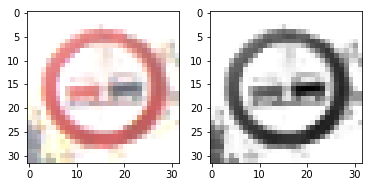

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(image)
print(y_train[index])

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
axes[1].imshow(gray_image, cmap="gray")

plt.show()

<Container object of 43 artists>

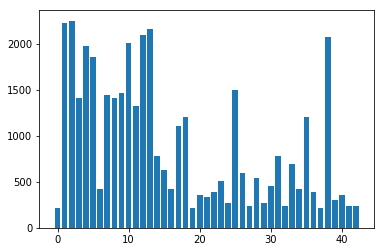

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
data_dist = np.asarray((unique, counts)).T

plt.bar(unique, counts)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

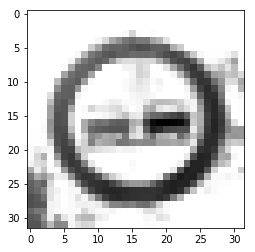

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def images_to_grayscale(X):
    
    X_train_gray = np.empty([X.shape[0], X.shape[1], X.shape[2], 1])
    for i, img in enumerate(X):
        gray = convert_to_grayscale(img)
        X_train_gray[i] = np.expand_dims(gray, axis=3)
        
    return X_train_gray
    
X_train_gray = images_to_grayscale(X_train)
                          
image = X_train_gray[index].squeeze()
plt.imshow(image, cmap="gray")


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

To preprocess the data I applied grayscale to all the images. This technique was mentioned by LeCun and said to improve performance of the algorithm. It would appear that by reducing the dimensions of the data, the neural network is able to focus on more important features of each image. 

The preprocess was straightforward, loop over all the images and using `cv2` convert the images to grayscale. Given that this reduces the dimensions of the input, I had to tweak the LeNet architecture to accept the new dimension.

**Answer:**

In [6]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [7]:
# This scripts generates 5 new images with transformations

n_transforms = 5
new_train = train
new_train['features'] = X_train_gray

generated = {'features': [], 'labels':[], 'coords':[], 'sizes':[]}
for i, image in enumerate(X_train_gray):
    
    for i in range(n_transforms):
        img = transform_image(image, 20, 10, 5)
        img = np.expand_dims(img, axis=3)
        generated['features'].append(img)
        generated['labels'].append(new_train['labels'][i])
        generated['coords'].append(new_train['coords'][i])
        generated['sizes'].append(new_train['sizes'][i])
        
# Add new image to dataset
new_train['features'] = np.append(new_train['features'], generated['features'], axis=0)
new_train['labels'] = np.append(new_train['labels'], generated['labels'], axis=0)
new_train['coords'] = np.append(new_train['coords'], generated['coords'], axis=0)
new_train['sizes'] = np.append(new_train['sizes'], generated['sizes'], axis=0)            
        
print("Done")

Done


In [8]:
from sklearn.model_selection import train_test_split

train = new_train
del new_train
del X_train

X_train, y_train = train['features'], train['labels']
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I split the data into training, validation and test sets. The database already contained a training and test set. So to create the validation set I split the training set into training and validation using `sklearn`. 

I did generate new data. Following Yacun's paper, I generated 5 new images for each original image. The generated images were transformed with Affine Transformation so to create the effect of being taken from different perspective points. I generated new data to make the model more robust, thinking that adding different perspectives will help the model be transformation-invariant. 

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Add Dropout Layer
    fc2_drop = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return logits


In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)

rate = 0.001

logits = LeNet(x, keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The core architecture is based on LeNet-5 with some additional changes.

Like LeNet, the architecture contains two sets of convolution plus pooling layers. Then there is a fully connected layer at the end, which then connects to the output. The convolution layers use the `relu` activation function. The differences with the LeNet architecture is a dropout wrapper to the last fully conected layer, so to reduce the chance of overfitting, and that the input image takes in a shape of (32, 32, 1) instead of (32, 32, 3) given that the images are in grayscale.

- Input = image in grayscale
- Layer 1 = convolution layer with relu activation
- Pooling
- Layer 2 = convolution layer with relu activation
- Pooling
- Layer 3 Fully Conected + Dropout
- Output Classifier

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.
EPOCHS = 10
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.937

EPOCH 2 ...
Validation Accuracy = 0.967

EPOCH 3 ...
Validation Accuracy = 0.966

EPOCH 4 ...
Validation Accuracy = 0.965

EPOCH 5 ...
Validation Accuracy = 0.981

EPOCH 6 ...
Validation Accuracy = 0.978

EPOCH 7 ...
Validation Accuracy = 0.983

EPOCH 8 ...
Validation Accuracy = 0.978

EPOCH 9 ...
Validation Accuracy = 0.986

EPOCH 10 ...
Validation Accuracy = 0.988

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

To train the model, I used the `AdamOptimizer` with batch sizes of *128*, *10* epochs and hyperparameters of learning rate of *0.01* and dropout probability for las layer of *0.6*.

Using `AdamOptimizer` permits the model to converge faster, compared to traditional Stochastic Gradient Descent. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started off using the basic LeNet algorith. Then I did the following to tweak the model and improve the performance:
1. Generate new data
2. Added a dropout wrapper to the last fully connected layer
3. Preprocess data and convert the images to grayscale

I started off whit LeNet because its a natural application for it. LeNet was built to classify the MNIST data, which is basically takin in images as input and outputting a one-hot enconded labels. THe general architecture to classify the traffic-signs is the same. 

Things I will try:
- Change last layer to accept also the results of the 1rst convolution

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

X_test = images_to_grayscale(X_test)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.856


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I've included 5 images that I found in the internet, or in the "wild". I tried to choose images that seemed to be taken outside, with some background that is not just a simple color.

Some of the qualities form these images that might make classification difficult is that they contain more "noise" or background and they have not been preprocessed like the ones in the initial database. 

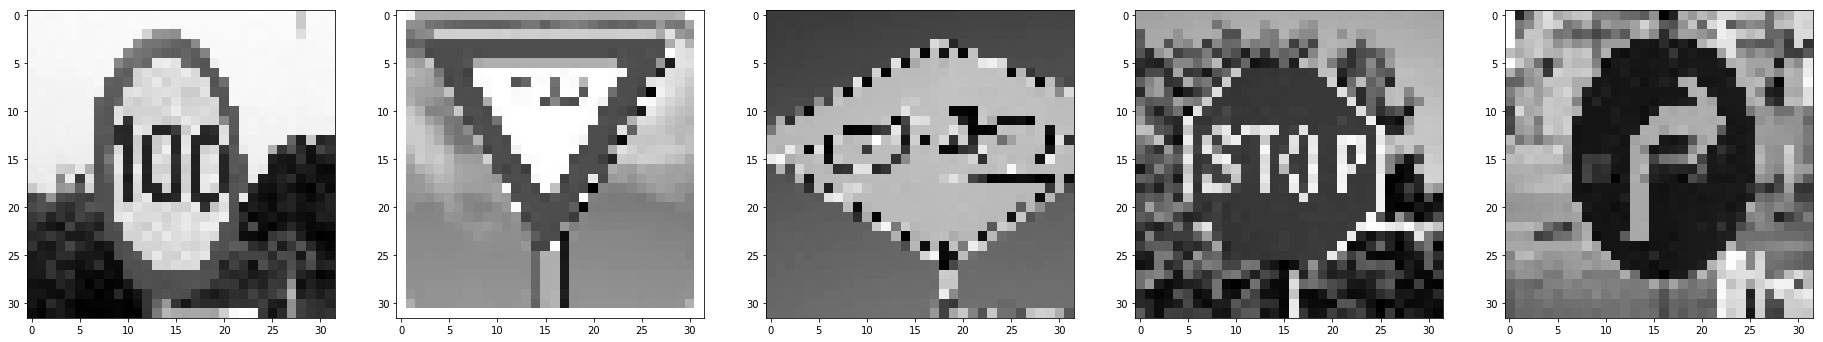

In [37]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# Images are saved 
import os
from PIL import Image

img_dir = 'real_images'
X_wild = np.empty([5, 32, 32, 1])

for i, name in enumerate(os.listdir(img_dir)):
    
    image = Image.open(img_dir + '/' + name)
    img_res = image.resize((32, 32))
    img_array = np.asarray(img_res)
    gray = convert_to_grayscale(img_array)
    X_wild[i] = np.expand_dims(gray, axis=3)


# Show the transformed signs from the wild
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(32, 160))  
for i, a in enumerate(axes):
    a.imshow(X_wild[i].squeeze(), cmap='gray')

plt.show()   


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
In short, no. The model clearly performs better on the testing dataset, although 5 points is arguably not enough to judge the accuracy of the model in the "wild".

The accuracy for the captued pictures was **60%**, 3 out of 5, compared to **85%** for the testing set. If given more captured images, we might see the model improve, although the images would definitley have to be preprocessed. 

My guess is that all the images in the trainint and testing set are better preprocessed in the sense that they are croped and only show the sign, while the new captued pictures show more "noise" or backgrond scenary. 

In [38]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
y_wild = np.array([7, 13, 29, 14, 33])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_wild, y_wild)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.600


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [46]:
y_wild = np.array([7, 13, 29, 14, 33])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    y_test_pred = sess.run(logits, feed_dict={x: X_wild, keep_prob: 1.0})
    
    softmax = sess.run(tf.nn.softmax(y_test_pred))
    top5 = sess.run(tf.nn.top_k(softmax, k=5))
    print(top5)



TopKV2(values=array([[  9.96686637e-01,   3.08753224e-03,   2.21131108e-04,
          2.84054408e-06,   1.81332143e-06],
       [  9.99986529e-01,   1.34506099e-05,   1.65814357e-12,
          3.36478024e-13,   1.93655381e-14],
       [  7.15318322e-01,   2.70542443e-01,   1.41305178e-02,
          8.14139730e-06,   2.66029190e-07],
       [  9.99999881e-01,   8.35179250e-08,   5.84963805e-12,
          3.62080483e-13,   1.34039698e-13],
       [  9.90143180e-01,   9.74277034e-03,   4.75215384e-05,
          3.12533411e-05,   1.36702101e-05]], dtype=float32), indices=array([[ 2,  5,  0,  3,  1],
       [13,  0,  5, 25,  3],
       [26, 25,  0, 18, 12],
       [14,  0, 34, 26, 25],
       [33, 14,  0, 35, 13]], dtype=int32))


The model seems to be very confident about all the predictions, with more than **99%** for all the predictions with the except of the 3rd one, which is the bicycle sign. It makes sense because the bicycle sign is the most distorted one (the correct prediction "29" is not even in the top-5)

For the 1rst sign, the 100 km/h sign, the correct label does not appear in the top-5 predictions as well. It first guess is 50 km/h and the other guesses are also km/h sings, but it did not choose the correct one, which is "7". 

